In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"


import acgan
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import twodlearn as tdl
import tensorflow as tf
import tensorflow_datasets as tfds
from functools import reduce
import matplotlib.pyplot as plt
BATCH_SIZE = 64
#acgan.data.DATA_DIR = '/data/marinodl/tensorflow_datasets'
session = tf.InteractiveSession()


In [2]:
dataset = acgan.data.load_celeb_a_128(BATCH_SIZE)
#dataset = acgan.data.load_mnist32(BATCH_SIZE)
input_shape = dataset.output_shapes.as_list()
print('input shape: {}'.format(input_shape))

Instructions for updating:
Colocations handled automatically by placer.


W0402 15:09:43.558088 139677936949056 deprecation.py:323] From /home/marinodl/research/2019/AssociativeGAN/env/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py:423: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


input shape: [None, 128, 128, 3]


In [3]:
import twodlearn.debug
@tdl.debug.stop_at_error
def _test():
    model = acgan.model.MSG_GAN(
        embedding_size=256,
        generator={'init_shape':(4, 4, 256),
                   'units': [256, 128, 64, 32, 3],
                   'kernels': 3,
                   'strides': 2},
        discriminator={'units':[32, 64, 128, 256, 256], #1024
                       'kernels':3,
                       'strides':2,
                       'dropout':None}
    )
    return model
model = _test()
#model.noise_rate.init(rate=0.001)
print('output shape: {}'.format(
    model.generator.compute_output_shape(
        input_shape=[None, 100])))

output shape: (?, 128, 128, 3)


In [4]:
iter = dataset.make_one_shot_iterator()
xreal = iter.get_next()

import twodlearn.debug
@tdl.debug.stop_at_error
def _test():
    gen = model.generator_trainer(
        BATCH_SIZE, learning_rate=0.0002
        # pyramid_loss={'scale': 1e-6},
        # regularizer={'scale': 1e-6}
        )
        #regularizer={'scale': 1e-5})
    dis = model.discriminator_trainer(
        BATCH_SIZE, xreal=xreal, learning_rate=0.0002
        # regularizer={'scale': 1e-6}
        )
        #regularizer={'scale': 1e-5})
    return gen, dis
gen, dis = _test()
tdl.core.variables_initializer(gen.variables).run()
tdl.core.variables_initializer(dis.variables).run()

Instructions for updating:
Use tf.cast instead.


W0402 15:09:45.472428 139677936949056 deprecation.py:323] From /home/marinodl/research/2019/AssociativeGAN/env/lib/python3.6/site-packages/tensorflow/python/keras/utils/losses_utils.py:170: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


W0402 15:09:46.476130 139677936949056 deprecation.py:323] From /home/marinodl/research/2019/AssociativeGAN/env/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


In [5]:
print([proj.input_shape for proj in model.generator.projections])
print([proj.units for proj in model.discriminator.projections])

[TensorShape([Dimension(None), Dimension(4), Dimension(4), Dimension(256)]), TensorShape([Dimension(None), Dimension(8), Dimension(8), Dimension(256)]), TensorShape([Dimension(None), Dimension(16), Dimension(16), Dimension(128)]), TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(64)]), TensorShape([Dimension(None), Dimension(64), Dimension(64), Dimension(32)])]
[32, 64, 128, 256, 256]


In [6]:
dis.xreal.shape.as_list()

[None, 128, 128, 3]

In [7]:
print('step {} | dis {} | gen {}'.format(dis.train_step.eval(), dis.loss.eval(), gen.loss.eval()) )

step 0 | dis 0.6901533007621765 | gen 0.693813145160675


In [8]:
MAX_UPDATE_STEPS = 100
def run_training(dis, gen, n_steps=1000, n_logging=100, session=None):
    def print_losses(progress_bar):
        info = 'step {} | dis {:.4f} | gen {:.4f} '.format(
            dis.train_step.eval(), dis.loss.eval(), gen.loss.eval())
        progress_bar.set_description(info)

    def update_log(steps, progres_bar):
        progress_bar.update(1)
        done = steps > 2*n_steps
        if steps % n_logging == 0:
            print_losses(progress_bar)
        return done, steps+1

    session = (session if session is not None
               else tf.get_default_session()
               if tf.get_default_session() is not None
               else tf.InteractiveSession())
    dis_loss, gen_loss = session.run([dis.loss, gen.loss])
    progress_bar = tqdm.tqdm(range(2*n_steps))
    done = False
    steps = 0
    # an each update of either network is considered an step
    while not done:
        # optimize discriminator
        # dis_steps = max(1, int(dis_loss//gen_loss))
        # dis_steps = min(dis_steps, MAX_UPDATE_STEPS)
        #dis_steps = (dis_steps if dis.train_step.eval() > 500
        #             else 1)  # only one during first iterations
        dis_steps = 1
        for j in range(dis_steps):
            _, dis_loss, gen_loss = session.run([dis.step, dis.loss, gen.loss])
            done, steps = update_log(steps, progress_bar)
            if (dis_loss < gen_loss) or done:
                break
        # optimize generator
        #gen_steps = max(1, int(gen_loss//dis_loss))
        #gen_steps = min(gen_steps, MAX_UPDATE_STEPS)
        gen_steps = 1
        for j in range(gen_steps):
            _, dis_loss, gen_loss = session.run([gen.step, dis.loss, gen.loss])
            done, steps = update_log(steps, progress_bar)
            if (gen_loss < dis_loss) or done:
                break
    progress_bar.close()

In [ ]:
acgan.train.run_training(dis=dis, gen=gen, n_steps=1000, n_logging=10)

step 15178 | dis 0.5471 | gen 0.9902 :  48%|████▊     | 954/2000 [04:10<04:46,  3.66it/s]

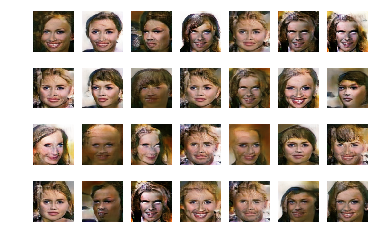

In [113]:
xsim = dis.xsim.eval()
for i in range(4*7):
    plt.subplot(4,7, i+1)
    plt.imshow(np.squeeze((xsim[i][:,:,:]+1)*0.5))
    plt.axis('off')

In [114]:
[layer.units for layer in model.generator.layers[1:]]

[256, 128, 64, 32, 3]

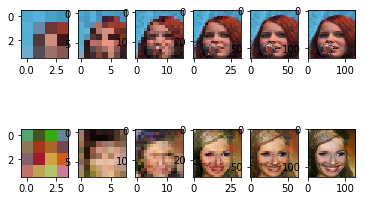

In [116]:
fig, ax = plt.subplots(2, len(dis.real_pyramid))
real_pyramid_ = session.run(dis.real_pyramid)
sim_pyramid_ = session.run(dis.sim_pyramid)
for idx in range(len(dis.real_pyramid)):
    ax[0, idx].imshow(np.squeeze(real_pyramid_[idx][1, ...]+1)*0.5)
    ax[1, idx].imshow(np.squeeze(sim_pyramid_[idx][1, ...]+1)*0.5)

In [45]:
import acgan.model.msg_gan
acgan.model.msg_gan.USE_BIAS

{'generator': False, 'discriminator': True}